<a href="https://colab.research.google.com/github/AshWN23/handwriting/blob/master/Nepali_handwriting_(consonents)_Generation_using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import tqdm
import cv2
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as T

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!git clone https://github.com/kcnishan/Nepali_handwritten_digits_recognition.git

Cloning into 'Nepali_handwritten_digits_recognition'...
remote: Enumerating objects: 92087, done.
remote: Total 92087 (delta 0), reused 0 (delta 0), pack-reused 92087 (from 1)
Receiving objects: 100% (92087/92087), 67.09 MiB | 23.26 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (92306/92306), done.


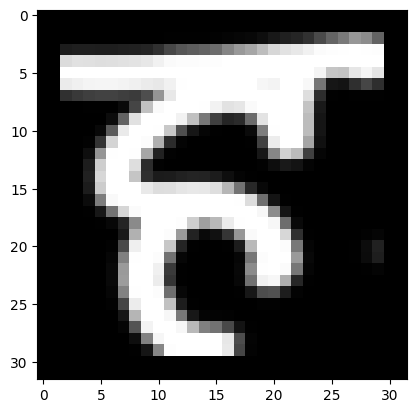

In [4]:
plt.imshow(cv2.imread('/content/Nepali_handwritten_digits_recognition/dataset/Test/consonants/character_33_ha/14884.png'))

In [5]:
X_img = []
train_path = '/content/Nepali_handwritten_digits_recognition/dataset/Train/consonants'
Test_path = '/content/Nepali_handwritten_digits_recognition/dataset/Test/consonants'
for each in os.listdir('/content/Nepali_handwritten_digits_recognition/dataset/Train/consonants'):
  print(each)
  for x in os.listdir(train_path+'/'+each):
    X_img.append([train_path+'/'+each+'/'+x, each])
    break

character_25_ma
character_6_cha
character_33_ha
character_28_la
character_10_yna
character_30_motosaw
character_14_dhaa
character_22_pha
character_35_tra
character_18_da
character_26_yaw
character_19_dha
character_11_taamatar
character_29_waw
character_31_petchiryakha
character_13_daa
character_4_gha
character_17_tha
character_7_chha
character_36_gya
character_23_ba
character_34_chhya
character_20_na
character_32_patalosaw
character_27_ra
character_3_ga
character_21_pa
character_8_ja
character_1_ka
character_5_kna
character_16_tabala
character_2_kha
character_24_bha
character_15_adna
character_9_jha
character_12_thaa


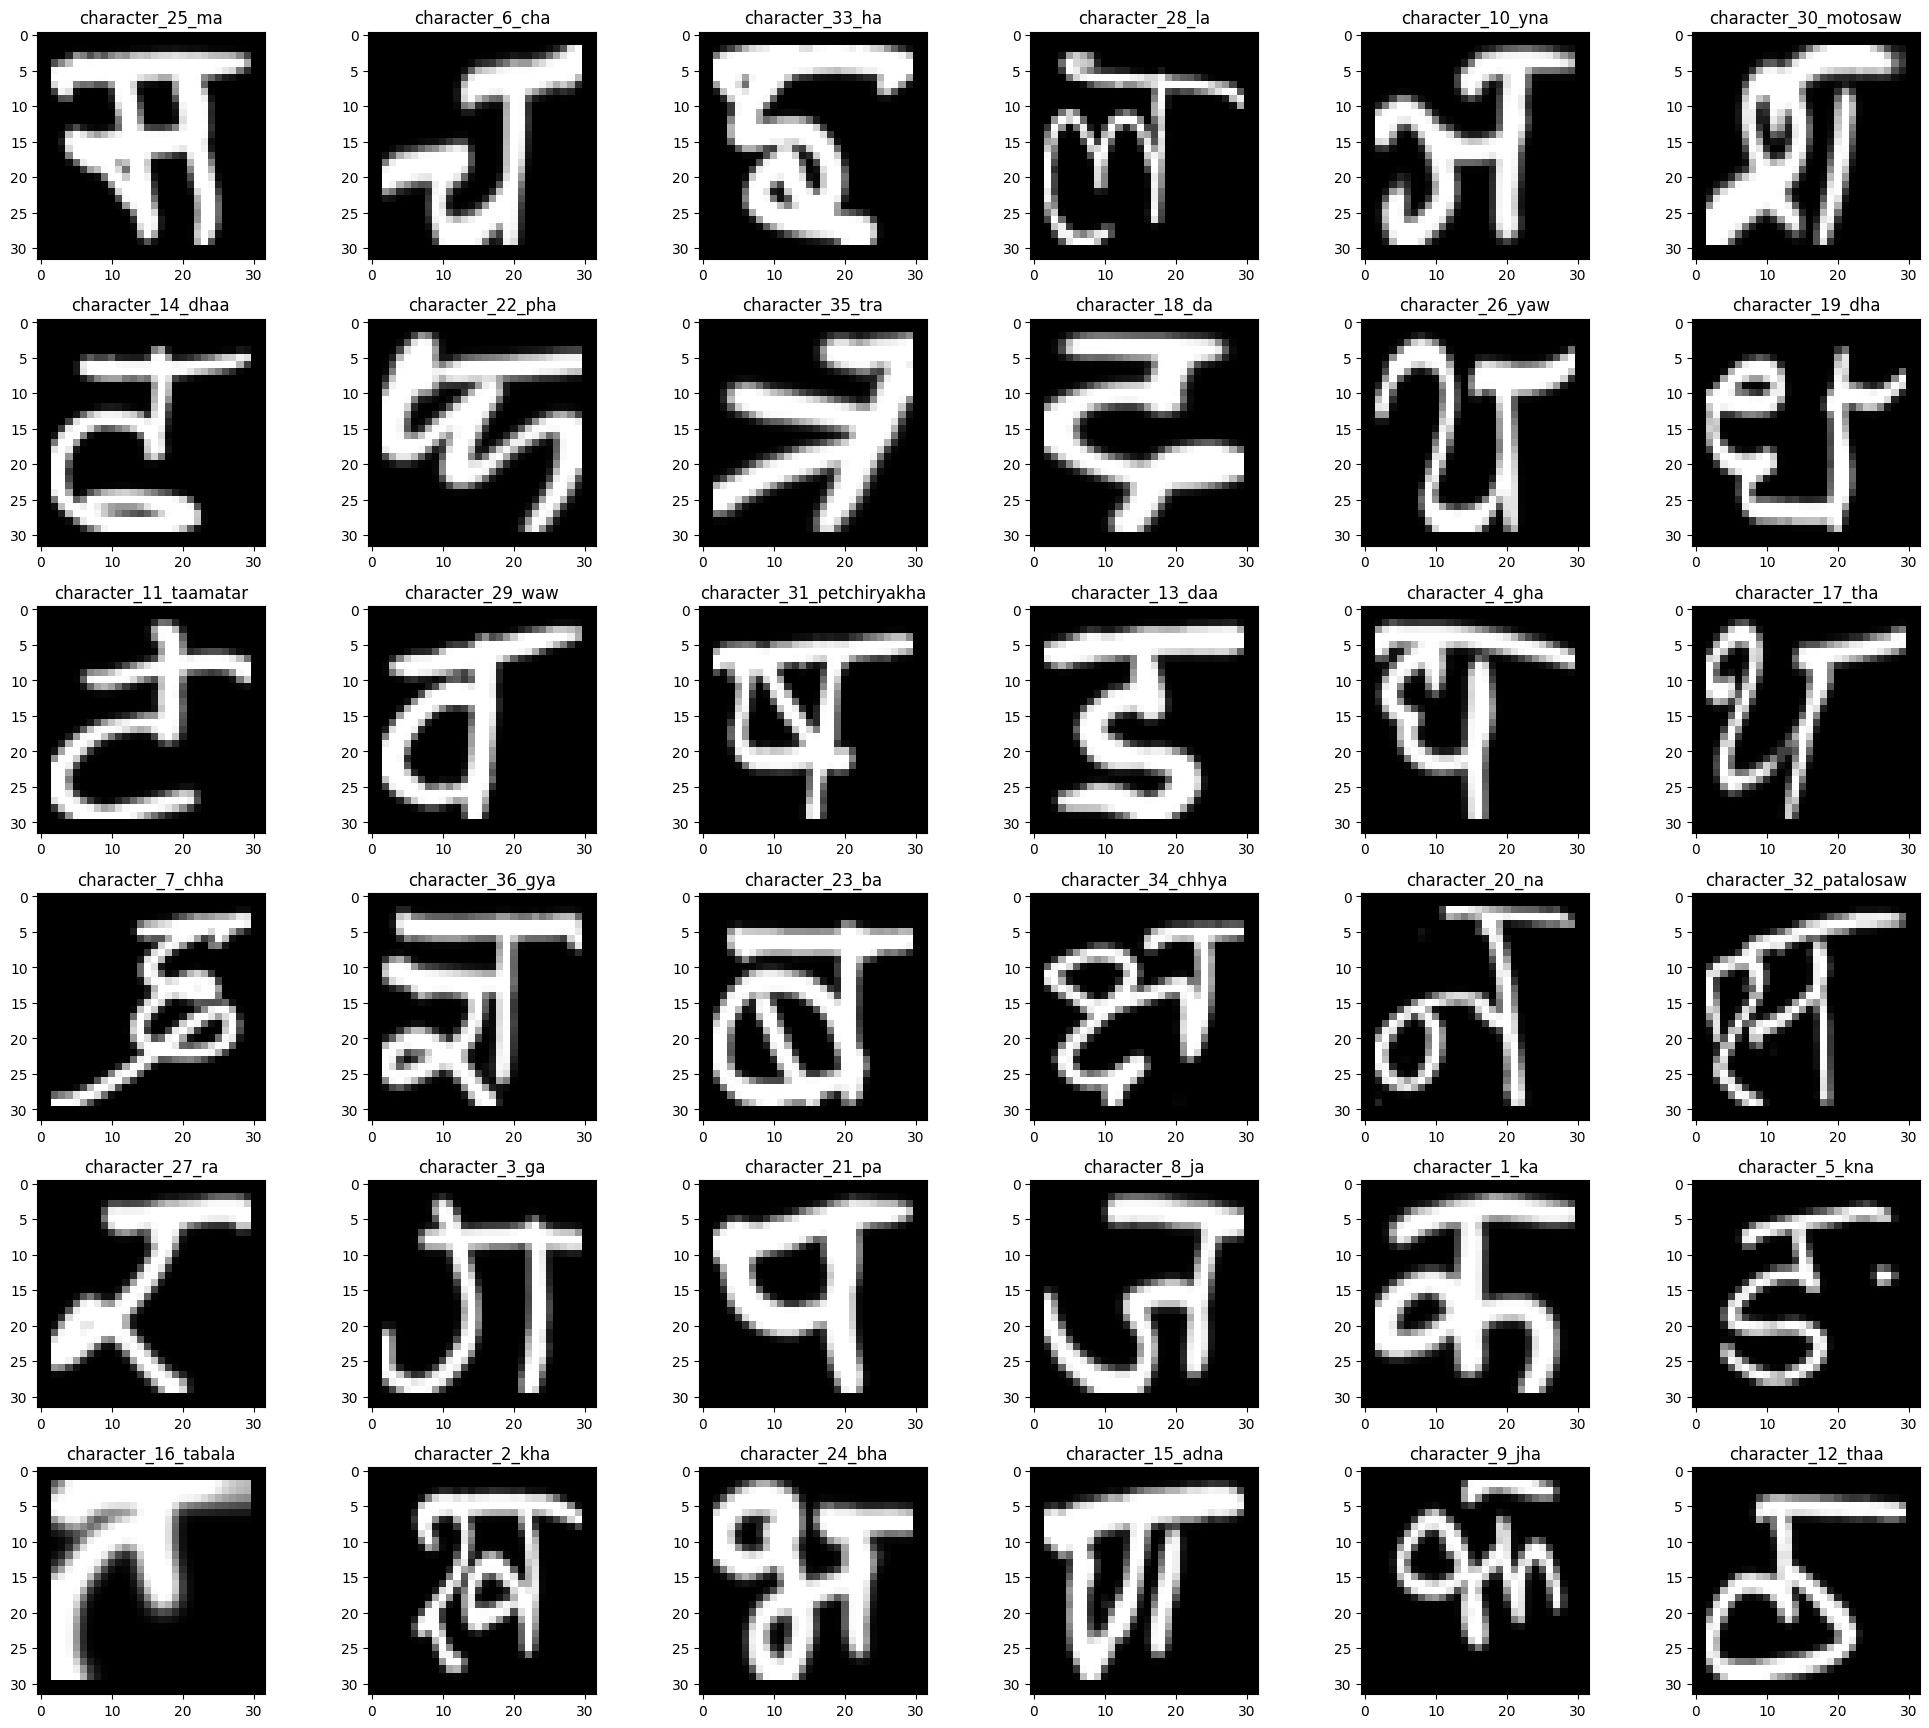

In [6]:
plt.figure(figsize=(20,20)) # specifying the overall grid size

for i in range(36):
    plt.subplot(7,6,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(cv2.imread(X_img[i][0]))
    plt.title(X_img[i][1])
    plt.tight_layout(pad=1.0)
plt.show()

In [7]:
img_path = []
label = []
for each in os.listdir(train_path):
  for x in os.listdir(train_path+'/'+each):
    img_path.append(train_path+'/'+each+'/'+x)
    label.append(each)

In [8]:
!rm -r '/content/Nepali_handwritten_digits_recognition/dataset/Test/consonants/character_22_pha/character_1_ka'

In [9]:
img_path_test = []
label_test = []
for each in os.listdir(Test_path):
  for x in os.listdir(Test_path+'/'+each):
    img_path_test.append(Test_path+'/'+each+'/'+x)
    label_test.append(each)

In [10]:
df = pd.DataFrame(list(zip(img_path, label)), columns=['path', 'label'])

In [11]:
df_test = pd.DataFrame(list(zip(img_path_test, label_test)), columns=['path', 'label'])

In [12]:
df.head()

,path,label
0,/content/Nepali_handwritten_digits_recognition...,character_25_ma
1,/content/Nepali_handwritten_digits_recognition...,character_25_ma
2,/content/Nepali_handwritten_digits_recognition...,character_25_ma
3,/content/Nepali_handwritten_digits_recognition...,character_25_ma
4,/content/Nepali_handwritten_digits_recognition...,character_25_ma


In [13]:
df_test.head()

,path,label
0,/content/Nepali_handwritten_digits_recognition...,character_25_ma
1,/content/Nepali_handwritten_digits_recognition...,character_25_ma
2,/content/Nepali_handwritten_digits_recognition...,character_25_ma
3,/content/Nepali_handwritten_digits_recognition...,character_25_ma
4,/content/Nepali_handwritten_digits_recognition...,character_25_ma


In [14]:
cv2.imread(df.path[0]).shape

(32, 32, 3)

In [15]:
LbE = LabelEncoder()
df.label =  LbE.fit_transform(df.label)
df_test.label =  LbE.fit_transform(df_test.label)

In [16]:
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test

,path,label
0,/content/Nepali_handwritten_digits_recognition...,35
1,/content/Nepali_handwritten_digits_recognition...,18
2,/content/Nepali_handwritten_digits_recognition...,10
3,/content/Nepali_handwritten_digits_recognition...,33
4,/content/Nepali_handwritten_digits_recognition...,3
...,...,...
10795,/content/Nepali_handwritten_digits_recognition...,31
10796,/content/Nepali_handwritten_digits_recognition...,7
10797,/content/Nepali_handwritten_digits_recognition...,29
10798,/content/Nepali_handwritten_digits_recognition...,9


In [17]:
df = df.sample(frac=1).reset_index(drop=True)
df

,path,label
0,/content/Nepali_handwritten_digits_recognition...,30
1,/content/Nepali_handwritten_digits_recognition...,20
2,/content/Nepali_handwritten_digits_recognition...,0
3,/content/Nepali_handwritten_digits_recognition...,15
4,/content/Nepali_handwritten_digits_recognition...,15
...,...,...
61195,/content/Nepali_handwritten_digits_recognition...,35
61196,/content/Nepali_handwritten_digits_recognition...,0
61197,/content/Nepali_handwritten_digits_recognition...,12
61198,/content/Nepali_handwritten_digits_recognition...,9


In [18]:
class LetterDataset(Dataset):
  def __init__(self, df):
    self.fpath = df.path
    self.label = df.label
    self.transform = T.Compose(
   [T.ToPILImage(),
    T.ToTensor(),
    T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   ),
    T.Grayscale(num_output_channels=1)
    ]
)

  def __len__(self):
    return len(self.fpath)

  def __getitem__(self, ix):
    img = self.fpath[ix]
    target = self.label[ix]
    img = cv2.imread(img)
    im = self.transform(img)
    return torch.tensor(im/255).to(device).float(), torch.tensor(target).long().to(device)

In [1]:
final_df = pd.concat([df, df_test])
final_df = final_df.reset_index(drop=True)

NameError: name 'pd' is not defined

In [ ]:
data =  LetterDataset(final_df)
img, label = data[100]
print(img.shape)
plt.imshow(img.cpu().reshape(32,32))
plt.title(label)

In [ ]:
def conv_layer(ni, no, kernel_size, stride, padding):
  return nn.Sequential(
      nn.ConvTranspose2d(ni, no, kernel_size, stride, padding, bias=False),
      nn.BatchNorm2d(no),
      nn.ReLU(),
  )

def disc_layer(ni, no, kernel_size,  stride, padding):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride, padding, bias=False),
      nn.BatchNorm2d(no),
      nn.LeakyReLU(0.2),
  )

In [ ]:
def weights_init(m):
               classname = m.__class__.__name__
               if classname.find('Conv') != -1:
                   nn.init.normal_(m.weight.data, 0.0, 0.02)
               elif classname.find('BatchNorm') != -1:
                   nn.init.normal_(m.weight.data, 1.0, 0.02)
                   nn.init.constant_(m.bias.data, 0)



class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.model = nn.Sequential(
        nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
        nn.BatchNorm2d(64*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
        nn.BatchNorm2d(64*4),
        nn.ReLU(True),
        nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
        nn.BatchNorm2d(64*2),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*2,1,4,2,1,bias=False),
        nn.Tanh()
        )
    self.apply(weights_init)
  def forward(self,input): return self.model(input)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self ):
    super(Discriminator, self).__init__()
    self.disc  = nn.Sequential(

        #input size=32*32
        nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
          #16*16
        nn.LeakyReLU(0.2),
        disc_layer(64, 64*2, 4,2,1), #8x8
        disc_layer(64*2, 64*4, 4,2,1),#4x4
        nn.Conv2d(64*4, 1, kernel_size=4,stride=2,padding=0),#1x1
        nn.Sigmoid()
    )

    self.apply(weights_init)
  def forward(self, input):
    return self.disc(input)

In [ ]:
z_dim =100
H,W = 32,32
N = 8
disc = Discriminator().to(device)
gen = Generator().to(device)


In [ ]:
from torchsummary import summary
summary(gen,(100,1,1),1)

In [ ]:
def calculateHWOUT(H_in, W_IN, padding, kernel_size, stride, max_pool_num):
    H_out = (((H_in + 2*padding - kernel_size) / stride ) +1) / max_pool_num
    W_out = (((W_IN + 2*padding - kernel_size) / stride ) +1) / max_pool_num
    return (int(H_out), int(W_out))
calculateHWOUT(4,4,1,4,2,1)

In [ ]:
def label_real(size):
  data = torch.ones(size)
  return data.to(device)

def label_fake(size):
  data = torch.zeros(size)
  return data.to(device)

In [ ]:
def create_noise(N,z_dim):
  return torch.randn(N, z_dim,1,1).to(device)

In [ ]:
# def save_generator_image(image, path):
#   save_image(image, path, normalize=True)

In [ ]:
image_size = 32
batch_size = 32
z_dim =100
beta1 = 0.5
lr=0.0002
epochs = 50
sample_size=8

In [ ]:
def get_data():
  data =  LetterDataset(final_df)
  trn_ldr = DataLoader(data, batch_size=batch_size, shuffle=True)
  return trn_ldr

In [ ]:
trn_ldr = get_data()

In [ ]:
loss_fn = nn.BCELoss()
optimizer_g = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
losses_g = []
losses_d = []

In [ ]:
# def train_disc(optimizer, data_real, data_fake):

#   b_size = len(data_real)
#   real_label = label_real(b_size).squeeze()
#   fake_label = label_fake(b_size)

#   optimizer.zero_grad()

#   output_real = disc(data_real).squeeze()

#   print(output_real.shape)
#   print('****')
#   print(real_label.shape)
#   loss_real = loss_fn(output_real, real_label)
#   # print(data_fake.shape)
#   output_fake = disc(data_fake)
#   loss_fake = loss_fn(output_fake, fake_label)

#   loss_real.backward()
#   loss_fake.backward()

#   optimizer.step()

#   return (loss_real + loss_fake)


def train_disc(optimizer,real_data, fake_data):
               optimizer.zero_grad()
               prediction_real = disc(real_data)
               error_real = loss_fn(prediction_real.squeeze(), \
                                 torch.ones(len(real_data)).to(device))
               error_real.backward()
               prediction_fake = disc(fake_data)
               error_fake = loss_fn(prediction_fake.squeeze(), \
                                 torch.zeros(len(fake_data)).to(device))
               error_fake.backward()
               optimizer.step()
               return error_real + error_fake

In [ ]:
def train_gen(optimizer,fake_data):
               optimizer.zero_grad()
               prediction = disc(fake_data)
               error = loss_fn(prediction.squeeze(), \
                            torch.ones(len(fake_data)).to(device))
               error.backward()
               optimizer.step()
               return error

In [ ]:
gen.train()
disc.train()
noise = create_noise(sample_size, z_dim)

In [ ]:
a = torch.randn(8,1,32,32)
plt.imshow(a[0].reshape(32,32))

In [ ]:
for i in range(50):
  loss_g = 0.0
  loss_d = 0.0
  print(f'Epoch: _________*****{i}*****_______')
  for ix, batch in tqdm.tqdm(enumerate((trn_ldr))):
    x, y = batch
    x = x.to(device)
    b_size = len(x)
    data_fake = gen(create_noise(b_size, z_dim)).detach()
    data_real = x
    loss_d +=train_disc(optimizer_d, data_real, data_fake)
    data_fake = gen(create_noise(b_size, z_dim))
    loss_g += train_gen(optimizer_g,data_fake)
  generated_image = gen(noise).cpu().detach()
  plt.imshow(generated_image[0].reshape(32,32))
  plt.show()
  print(loss_g, loss_d)
  epoch_loss_g = (loss_g / ix)
  epoch_loss_d = loss_d / ix
  losses_g.append(epoch_loss_g)
  losses_d.append(epoch_loss_d)
  print(f'Epoch: _________*****{i} Generator Training Loss : {epoch_loss_g} *****_______')
  print(f'Epoch: _________*****{i} Discriminator Training Loss : {epoch_loss_d} *****_______')



In [ ]:
epochs = np.arange(50) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,8))
plt.plot(epochs, torch.tensor(losses_g, device='cpu'), label='Generator_loss')
plt.plot(epochs, torch.tensor(losses_d).cpu(), label='Discriminator_loss')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
# plt.title('Training and Validation accuracy with 17000 data points used for training')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.show()

In [ ]:
torch.save(gen.state_dict(), 'genconst.pth')

In [ ]:
generated_img =  gen(create_noise(8, z_dim)).cpu().detach()
for i in range(len(generated_img)):
  plt.imshow(generated_img[i].reshape(32,32))
  plt.show()

In [ ]:
def preprocess_predict_data(img_path):
  img = cv2.imread(img_path)
  transform = T.Compose(
   [T.ToPILImage(),
    T.ToTensor(),
    T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   ),
    T.Grayscale(num_output_channels=1)
    ]
  )
  img = transform(img).to(device)
  return img

def predict(x, model):
  img = preprocess_predict_data(x)
  img = img.unsqueeze_(0)
  pred = model(img)
  return torch.max(pred.data, 1)